In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from shapely.geometry import Point, Polygon

In [2]:
# Load the provinces
pdf = gpd.read_file("geoserver-GetFeature.json")

In [3]:
def transform_crs(dframe):
    dframe.to_crs("epsg:4326", inplace=True)

transform_crs(pdf)

<AxesSubplot:>

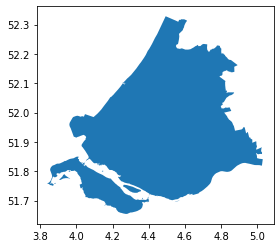

In [4]:
# Should display the Zuid-Holland municipality.
pdf.loc[[8],'geometry'].plot()

In [31]:
import requests

base_url = "https://geodata.zuid-holland.nl/geoserver/klimaat/wfs?"
request = "request=GetFeature&service=WFS&version=1.1.0"
data = "&typeName=KA_KWETSBAARHEID_PANDEN_DIJKDOORBRAAK"
out_format = "&outputFormat=json"

url = base_url + request + data + out_format

# By default 1 000 000 records are requested. Since there are 1,293,477 records
# I'll merge the 2 requests into a single df on the gid.

panden = requests.get(url + "&startIndex=0")
first_df = gpd.GeoDataFrame.from_features(panden.json())
first_df.set_index('gid')

panden = requests.get(url + "&startIndex=1000000")
last_df = gpd.GeoDataFrame.from_features(panden.json())
last_df.set_index('gid')

df = pd.concat([first_df, last_df])
df.tail()

,geometry,ogc_fid,gid,wp_waterho,wp_weinig_
293472,"MULTIPOLYGON Z (((97186.336 464097.461 43.325,...",689548,8997790,0.188,0
293473,"MULTIPOLYGON Z (((97183.845 464109.041 43.325,...",689549,8997791,0.138,0
293474,"MULTIPOLYGON Z (((97190.606 464207.931 43.323,...",689550,8997792,0.480,0
293475,"MULTIPOLYGON Z (((97171.186 464296.171 43.322,...",689551,8997793,0.319,0
293476,"MULTIPOLYGON Z (((97045.526 464086.841 43.325,...",689552,8997794,0.255,0


In [32]:
df.shape

(1293477, 5)

In [13]:
import numpy as np

df['wp_waterho_log'] = np.log(df['wp_waterho'])

In [14]:
df.to_crs("epsg:4326", inplace=True)

The OMS data is downloaded from [geofabrik.de](http://download.geofabrik.de/europe/netherlands/noord-holland-latest-free.shp.zip)

In [15]:
# http://download.geofabrik.de/europe/netherlands/noord-holland-latest-free.shp.zip
# http://download.geofabrik.de/osm-data-in-gis-formats-free.pdf
folder = 'zuid-holland-latest-free/'

osm_basemap = gpd.read_file(folder + 'gis_osm_waterways_free_1.shp')
osm_basemap.to_crs("epsg:4326", inplace=True)

In [16]:
osm_pl = gpd.read_file(folder + 'gis_osm_places_free_1.shp')

In [17]:
osm_water = gpd.read_file(folder + 'gis_osm_water_a_free_1.shp')

In [18]:
cities = osm_pl.loc[osm_pl['population'] > 100000]
cities.to_crs("epsg:4326")
cities = cities.drop([141])

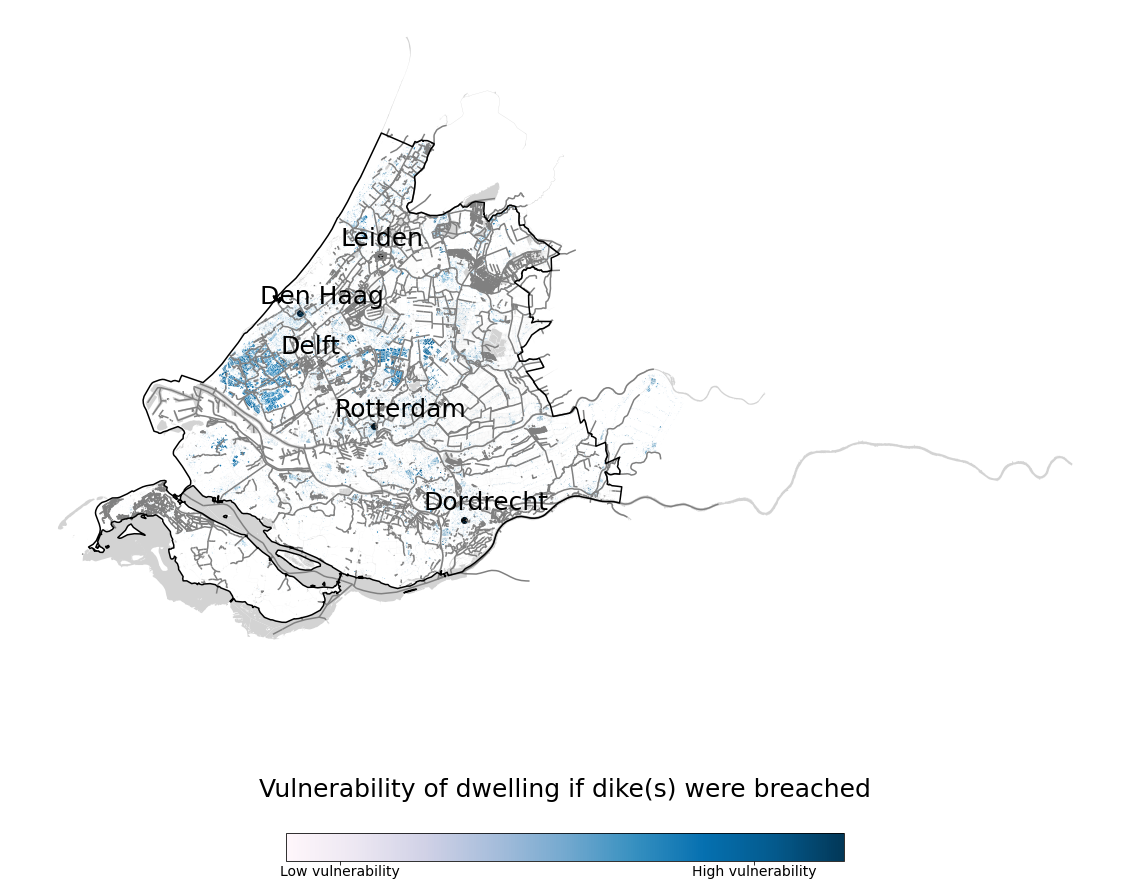

In [19]:
fig, ax = plt.subplots(1,1,figsize=(20,20))

cities.plot(ax=ax, color='black')

for x, y, label in zip(cities.geometry.x, cities.geometry.y, cities.name):
    ax.annotate(label, xy=(x, y), xytext=(-40, 10), 
                textcoords="offset points", fontsize=25, color="black")

osm_basemap.plot(ax = ax, color='grey')

osm_water.plot(ax = ax, color='lightgrey')

pdf.loc[[8],'geometry'].boundary.plot(ax = ax, edgecolor='black')

df.plot("wp_waterho_log", cmap='PuBu', legend=True, ax = ax, 
        legend_kwds={'orientation':'horizontal', 'shrink': 0.5, 'ticks': [-6,1]})

ax.set_title('Vulnerability of dwelling if dike(s) were breached',fontsize=25, y=-0.2)
ax.set_axis_off()

cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=14 ,pad=0.5)
xticks = cb_ax.get_xticks()

dict_urb={-6: "Low vulnerability", 1:'High vulnerability'}
cb_ax.set_xticklabels([x if x not in dict_urb else dict_urb[x] for x in xticks])

plt.savefig('challenge_blue_TEMP.jpg', bbox_inches='tight')